# Ensemble Methods. Stacking and Blending. Useful tips

<img src="../../img/lets_stack.jpg">

@Qovaxx

Наверное каждый сталкивался с ситуацией, когда несколько дней многократных попыток повысить качество модели оказывались безрезультатными, будь то задание для курса или спортивное соревнование kaggle. Оказывается есть вариант, как пробить это плато и взять новый рубеж - ансамблирование моделей. Многие скажут, что тут все достаточно просто, - так и есть отвечу я, но это тоже искусство, которым необходимо овладеть.

В текущем туториале мы приоткроем дверь в мир ансамблей и композиций моделей и попробуем слегка систематизировать информацию. Подробней остановимся на стэкинге и блендинге, их разных поюсах, минусах и реализациях. В конце вас ждет большая подборка советов для построения ансамблей. Ну что ж, поехали.

Общая идея ансамблирования: с помощью нескольких слабых классификаторов создать такое решающее правило, с помощью которого можно было бы повысить точность предсказания и сделать один сильный мета-классификатор.

Несколько основных причин создания ансамблей и композиций алгоритмов:
* существует несколько классификаторов решающих одну задачу классификации **в разном контексте**. Например, идентификация человека по его лицу, голосу, почерку и т.д.;
* иногда доступен более чем один набор данных, полученных из **разных** источников или созданных в **разные** периоды времени (Яндекс погода использует нечто подобное);
* разные классификаторы тренированные на одном наборе данных могут не отличаться по качеству, но иметь сильные **локальные различия**. Так, каждый классификатор может иметь свою область признаков, где он сильнее остальных;
* некоторые классификаторы (например нейронные сети) могут иметь разные результаты в зависимости от **инициализации**.

# Архитектуры

Различные схемы комбинаций базовых классификаторов можно поделить на 3 большие группы:
* **parallel** - базовые алгоритмы работают независимо (average, voting, stacking);
* **cascading** - базовые алгоритмы выстраиваются в линейную последовательность (AdaBoost, GradientBoosting);
* **hierarchical** - базовые алгоритмы выстраиваются в структуру напоминающую дерево решений (Hierarchical mixture of local experts).

Статичные комбинаторы по типу parallel (голосование, взвешенное, среднее), позволяют легко объединяться в команду с другими людьми, например в соревнованиях Kaggle. Таким образом вы независимо комбинируете ваши csv файлы с решениями, которые в свою очередь могут быть другими ансамблями.

Не путайте hierarchical с многоуровневыми ансамблями.

# Комбинаторы

Комбинатор - это модуль, стоящий над базовыми алгоритмами и преобразующий их пространство оценок в пространство ответов. Комбинаторы могут быть статичным и тренируемыми, адаптивными и не адаптивными. Под адаптивностью понимается, способность комбинатора оценивать вес для каждого базового алгоритма. Кроме того разные комбинаторы ожидают на вход разные входные данные: вероятности (confidence), ранк, лейблы классов (abstract). Вот некоторые варианты комбинаторов:

* **Voting, Weighted Voting** - parallel, abstract
* **Sum, Min, Max, Mean, Median, Product** - parallel, confidence
* **Generalized ensemble** - parallel, trainable, confidence
* **Adaptive weighting** - parallel, trainable, adaptive, confidence
* **Stacking, Blending, Feature-Weighted Linear Stacking** - parallel, trainable, confidence
* **Borda count** - parallel, trainable, rank
* **Logistic Regression over Ranks** - parallel, trainable, rank confidence
* **Class set reductuin** - parallel cascading, trainable, rank confidence
* **Dempsler-Shafor** - parallel, trainable, rank, confidence
* **Fuzzy Integrals** - parallel, trainable, confidence
* **Mixture of Local Experts** - parallel, trainable, adaptive, confidence
* **Hierarchical Mixture of Local Experts** - hierarchical, parallel, trainable, adaptive, confidence
* **Associate switch** - parallel, trainable, adaptive, abstract
* **Gradient boosting, Adaboost, Arcing, BrownBoost, GentleBoost etc** - cascade, trainable, abstract
* **Neural Tree** - hierarchical, trainable, confidence
* **DECORATE (Diverse Ensemble Creation by Oppositional Relabeling of Artificial Training Examples)**
* **Deep Stacking Network** - cascade, trainable


# Способы разнообразить ансамбли

В основе созданий всех ансамблей лежит идея независимости и разнообразия. Пара данные-классификатор, лежащие в основе всех схем, должны быть максимально разнообразными. Несколько таких способов, с точки зрения данных:

* бэггинг
* метод случайных подространств
* бэггинг + метод случайных подпространств (как в random forest)
* разное пространство признаков
* разные тренировочные сессии - например применяется в случае нейронных сетей

*бэггинг я отнес в эту категорию, так как по сути это метод создания различных подвыборок на основе бутстрапа, где для комбинации базовых алгоритмов используется голосование большинством или усреднение*

<img src="../../img/stack_blendings.jpg">

# Непосредственно стэкинг & блендинг

Стекинг и блендинг - одни из самых известных методов ансамблирования, в котором за ансамбль отвечают не простые операции усреднения, а другой мета-алгоритм. Часто они превосходит по качеству базовые алгоритмы.

Блендинг считается более простой версией стэкинга, хотя иногда люди используют эти термины взаимозаменяемо. Если в двух словах, то в блендинге тренировочные данные делятся на 2 части, по типу hold-out, а в стэкинге на несколько, по типу out-of-fold. Ниже поговорим об это более подробно.

Давайте же взглянем на то, с помощью чего вытаскиваются топовые решения в соревнованиях kaggle.

*Для определенности будем решать задачу бинарной классификаци, где уровень ансамбля не превышает одного. Каждую схему ансамблирования запустим 10 раз, чтобы получить более точные результаты. Напомню, что здесь не стоит цель получить максимальное качество.*

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(12, 10)})

from numpy.random import normal
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle

RANDOM_STATE = 17

Возьмем искуственный пример с двухмерным пространством признаков. Линия классов сложная и нелинейная.

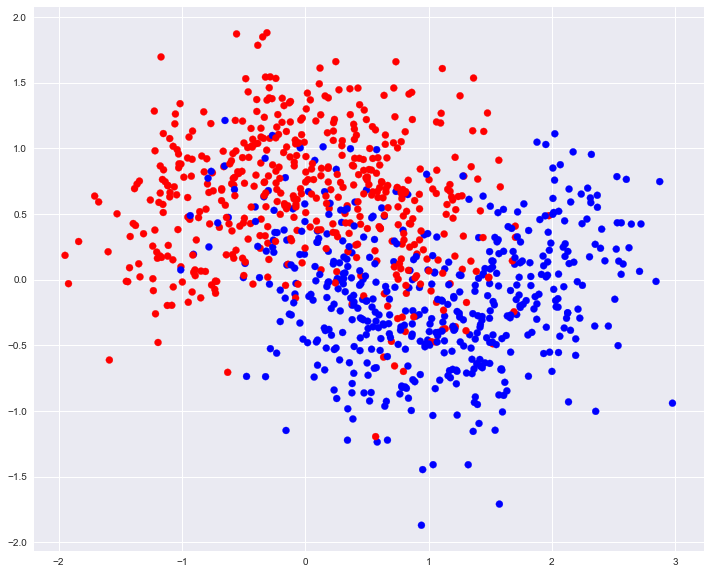

In [13]:
X, y = make_moons(n_samples=1000, random_state=RANDOM_STATE, noise=0.4)
plt.scatter(X[:, 0], X[:, 1], c=pd.Series(y).map({0:'red', 1:'blue'}));

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

Создадим много разных классификаторов, для которых проведем селекцию

In [16]:
classifiers = [KNeighborsClassifier(metric='manhattan', n_neighbors=52),
               KNeighborsClassifier(metric='manhattan', n_neighbors=118),
               KNeighborsClassifier(metric='chebyshev', n_neighbors=141),
               KNeighborsClassifier(metric='chebyshev', n_neighbors=94),
               KNeighborsClassifier(metric='euclidean', n_neighbors=27),
               KNeighborsClassifier(metric='euclidean', n_neighbors=86),
               LogisticRegression(C=32, penalty='l1', class_weight=None, fit_intercept=True, max_iter=150, tol=0.1),
               LogisticRegression(C=0.005, penalty='l1', class_weight=None, fit_intercept=False, max_iter=100, tol=0.01),
               LogisticRegression(C=0.0001, penalty='l2', class_weight=None, fit_intercept=True, max_iter=150, tol=1e-06),
               LogisticRegression(C=96, penalty='l1', class_weight='balanced', fit_intercept=True, max_iter=50, tol=0.0001),
               LogisticRegression(C=66, penalty='l2', class_weight='balanced', fit_intercept=False, max_iter=50, tol=0.1),
               LogisticRegression(C=54, penalty='l2', class_weight='balanced', fit_intercept=False, max_iter=450, tol=0.001),
               GradientBoostingClassifier(n_estimators=50, learning_rate=0.005, max_depth=12, max_features=0.8, min_samples_leaf=2, subsample=0.2),
               GradientBoostingClassifier(n_estimators=50, learning_rate=0.01, max_depth=5, max_features=0.6, min_samples_leaf=10, subsample=0.8),
               GradientBoostingClassifier(n_estimators=200, learning_rate=0.001, max_depth=90, max_features=0.5, min_samples_leaf=20, subsample=0.2),
               GradientBoostingClassifier(n_estimators=150, learning_rate=50, max_depth=24, max_features=0.1, min_samples_leaf=28, subsample=0.3),
               GradientBoostingClassifier(n_estimators=50, learning_rate=0.01, max_depth=20, max_features=0.6, min_samples_leaf=24, subsample=0.7),
               GradientBoostingClassifier(n_estimators=500, learning_rate=1, max_depth=42, max_features=0.2, min_samples_leaf=26, subsample=0.9),
               GradientBoostingClassifier(n_estimators=500, learning_rate=1, max_depth=22, max_features=0.8, min_samples_leaf=2, subsample=0.2),
               SVC(probability=True, C=2, kernel='rbf'),
               SVC(probability=True, C=0.005, kernel='rbf'),
               SVC(probability=True, C=700, kernel='rbf'),
               SVC(probability=True, C=0.5, degree=3, kernel='poly'),
               SVC(probability=True, C=52, degree=2, kernel='poly'),
               SVC(probability=True, C=72, degree=4, kernel='poly'),
               SVC(probability=True, C=200, kernel='sigmoid'),
               SVC(probability=True, C=2, kernel='sigmoid')]
classifiers_names = ['knn1', 'knn2', 'knn3', 'knn4', 'knn5', 'knn6',
                     'lr1', 'lr2', 'lr3', 'lr4', 'lr5', 'lr6',
                     'gb1', 'gb2', 'gb3', 'gb4', 'gb5', 'gb6', 'gb7',
                     'svm1', 'svm2', 'svm3', 'svm4', 'svm5', 'svm6', 'svm7', 'svm8']

In [17]:
classifiers_predictions = pd.DataFrame()
for name, classifier in zip(classifiers_names, classifiers):
    classifier.fit(X_train, y_train)
    train_predictions = classifier.predict_proba(X_train)[:, 1]
    test_predictions = classifier.predict_proba(X_test)[:, 1]
    
    classifiers_predictions[name] = test_predictions
    print('{0}: ({1} - {2})'.format(name,
                                    round(roc_auc_score(y_train, train_predictions), 3),
                                    round(roc_auc_score(y_test, test_predictions), 5)))

knn1: (0.926 - 0.91812)
knn2: (0.917 - 0.91919)
knn3: (0.917 - 0.92087)
knn4: (0.92 - 0.92176)
knn5: (0.926 - 0.9149)
knn6: (0.92 - 0.92192)
lr1: (0.896 - 0.90389)
lr2: (0.5 - 0.5)
lr3: (0.87 - 0.88385)
lr4: (0.896 - 0.90398)
lr5: (0.896 - 0.90429)
lr6: (0.896 - 0.90456)
gb1: (0.954 - 0.90234)
gb2: (0.947 - 0.91085)
gb3: (0.901 - 0.8992)
gb4: (0.631 - 0.61824)
gb5: (0.933 - 0.91041)
gb6: (1.0 - 0.88782)
gb7: (0.704 - 0.67692)
svm1: (0.916 - 0.91385)
svm2: (0.874 - 0.88096)
svm3: (0.921 - 0.91314)
svm4: (0.904 - 0.89696)
svm5: (0.772 - 0.74284)
svm6: (0.767 - 0.74253)
svm7: (0.718 - 0.76711)
svm8: (0.723 - 0.77178)


Возьмем классификаторы, которые не переобучились и имеют auc больше 0.9

In [18]:
classifiers_predictions = classifiers_predictions[['knn1', 'knn2', 'knn3', 'knn4', 'knn5', 'knn6',
                                                   'lr1', 'lr3', 'lr4', 'lr5', 'lr6',
                                                   'gb1', 'gb2', 'gb3', 'gb5',
                                                   'svm1', 'svm2', 'svm3', 'svm4']]

Построим корреляционную матрицу их ответов. Идея заключается в том, чтобы выбрать для ансамбля модели примерно одного качество и с наименьшей корреляцией

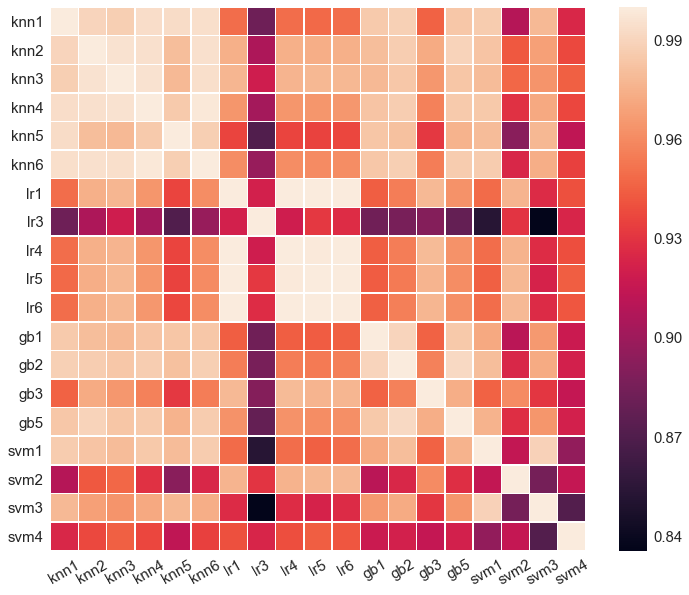

In [20]:
sns.heatmap(classifiers_predictions.corr(), linewidths=.5);
plt.yticks(rotation=0);
plt.xticks(rotation=30);
sns.set(font_scale=2)

Найдем менее коррелированные пары классификаторов (вы можете следовать какому-нибудь другому методу поиска таких моделей)

In [21]:
min_correlation = np.argwhere(np.asarray(classifiers_predictions.corr()) < 0.9)
selected_classifiers = list()
for x, y in min_correlation:
    selected_classifiers.append(classifiers_predictions.columns[x])
    selected_classifiers.append(classifiers_predictions.columns[y])
selected_classifiers = set(selected_classifiers)
selected_classifiers

{'gb1',
 'gb2',
 'gb3',
 'gb5',
 'knn1',
 'knn5',
 'knn6',
 'lr3',
 'svm1',
 'svm2',
 'svm3',
 'svm4'}

Отберем их

In [22]:
classifiers = [KNeighborsClassifier(metric='manhattan', n_neighbors=52),
               KNeighborsClassifier(metric='euclidean', n_neighbors=27),
               KNeighborsClassifier(metric='euclidean', n_neighbors=86),
               LogisticRegression(C=0.0001, penalty='l2', class_weight=None, fit_intercept=True, max_iter=150, tol=1e-06, random_state=RANDOM_STATE),
               GradientBoostingClassifier(n_estimators=50, learning_rate=0.005, max_depth=12, max_features=0.8, min_samples_leaf=2, subsample=0.2, random_state=RANDOM_STATE), 
               GradientBoostingClassifier(n_estimators=50, learning_rate=0.01, max_depth=5, max_features=0.6, min_samples_leaf=10, subsample=0.8, random_state=RANDOM_STATE),
               GradientBoostingClassifier(n_estimators=50, learning_rate=0.01, max_depth=20, max_features=0.6, min_samples_leaf=24, subsample=0.7, random_state=RANDOM_STATE),
               SVC(probability=True, C=2, kernel='rbf', random_state=RANDOM_STATE),
               SVC(probability=True, C=0.005, kernel='rbf', random_state=RANDOM_STATE),
               SVC(probability=True, C=700, kernel='rbf', random_state=RANDOM_STATE)]

classifiers_names = ['knn1','knn5', 'knn6',
                     'lr3',
                     'gb1', 'gb2',  'gb5',
                     'svm1', 'svm2', 'svm3']

In [23]:
def plot_decision_surface(clf, X_test, y_test, title):
    xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 20), cmap=plt.cm.Spectral, alpha=0.5)

    plt.scatter(X_test[:, 0], X_test[:, 1], c=pd.Series(y_test).map({0:'red', 1:'blue'}), s=20, alpha=1.0)
    plt.xlim([-2, 3])
    plt.ylim([-3, 3])
    plt.axis('off')
    plt.title(title)

Построим для них границу принятия решений

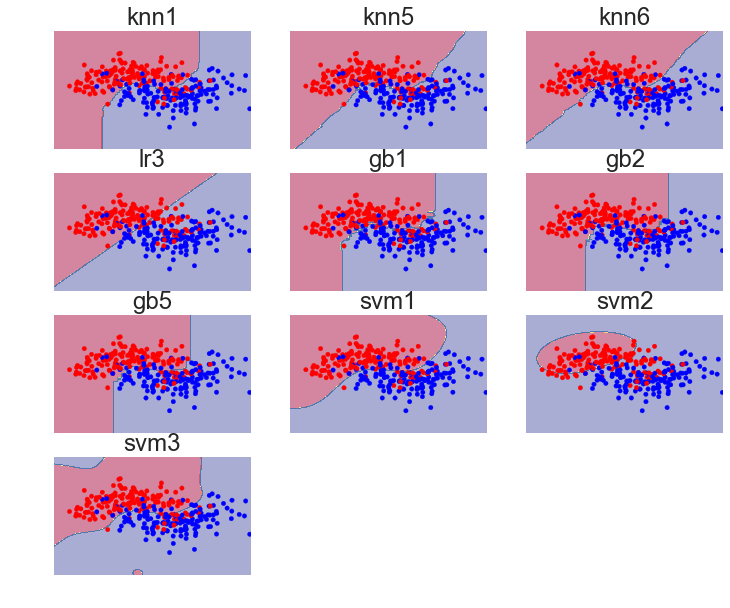

In [24]:
subplot_count = 1

for name, classifier in zip(classifiers_names, classifiers):
    plt.subplot(4, 3, subplot_count)
    classifier.fit(X_train, y_train)
    plot_decision_surface(classifier, X_test, y_test, name)
    subplot_count += 1

In [25]:
xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))

## Простейшая схема блендинга

Тренировочную выборку делят на 2 части. Базовые алгоритмы обучают на 1 части и сразу же делают предсказания для второй части и для тестовых данных. Мета-признаки полученные на второй части идут на обучение мета-алгоритма, а мета-признаки тестовых данных уже используются для формирования финального предсказания.

Преимущества блендинга:
* проще стэкинга, меньшая вычислительная сложность;
* защищен от утечки информации в отличие от стэкинга (причина в out-of-fold);
* вам не нужно делиться seed от stratified folds с вашими напарниками.
   
Недостатки:
* базовые алгоритмы и мета-алгоритм используют не всю обучающую выборку;
* можно переобучиться на hold-out выборке;
* out-of-fold более стабилен нежели использование просто hold-out выборки.

<img src="../../img/simple_blending.png">

In [26]:
def simple_blending(basic_algorithms, meta_algorithm, X_train, X_test, y_train, part1_ratio=0.9, random_state=None):
    X_train_part1, X_train_part2,\
    y_train_part1, y_train_part2 = train_test_split(X_train, y_train, test_size=1-part1_ratio, random_state=random_state)

    meta_features_part2 = np.zeros((X_train_part2.shape[0], len(basic_algorithms)))
    meta_features_test = np.zeros((X_test.shape[0], len(basic_algorithms)))

    for index, basic_algorithm in enumerate(basic_algorithms):
        basic_algorithm.fit(X_train_part1, y_train_part1)

        part2_predictions = basic_algorithm.predict_proba(X_train_part2)[:, 1]
        meta_features_part2[:, index] = part2_predictions

        test_predictions = basic_algorithm.predict_proba(X_test)[:, 1]
        meta_features_test[:, index] = test_predictions

    meta_algorithm.fit(meta_features_part2, y_train_part2)

    return meta_algorithm.predict_proba(meta_features_test)[:, 1]

In [27]:
experiments = list()
for i in range(1, 10):
    simple_blending_predictions = simple_blending(classifiers,
                                              LogisticRegression(C=5, random_state=RANDOM_STATE),
                                              X_train, X_test, y_train,
                                              part1_ratio=0.9,
                                              random_state=i)
    experiments.append(roc_auc_score(y_test, simple_blending_predictions))
print('mean roc_auc: {0}\nstd: {1}'.format(round(np.mean(experiments), 4), round(np.std(experiments), 5)))

mean roc_auc: 0.9213
std: 0.00186


В простом варианте получили результаты сравнимые с лучшей моделью, но несомненно такой ансамбль гораздо стабильней.

(-3.0, 3.0, -3.0, 3.0)

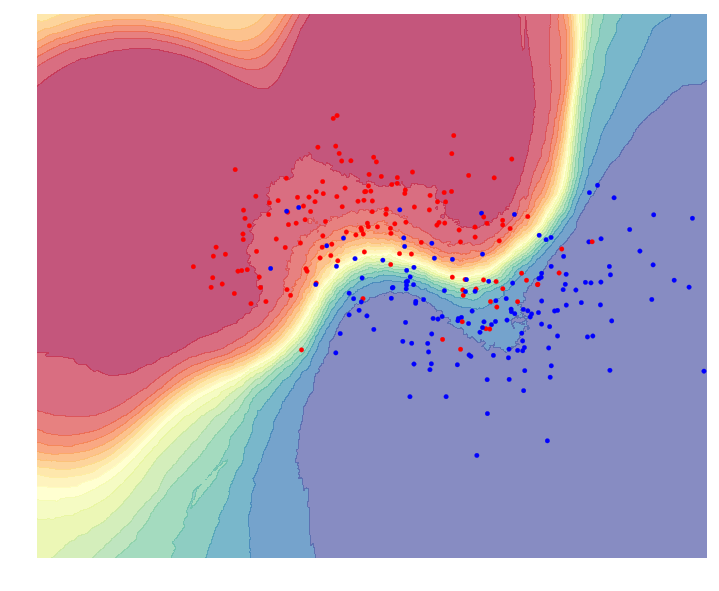

In [28]:
surface = simple_blending(classifiers,
                    LogisticRegression(C=5, random_state=RANDOM_STATE),
                    X_train, np.c_[xx.ravel(), yy.ravel()], y_train,
                    part1_ratio=0.9,
                    random_state=RANDOM_STATE).reshape(xx.shape)

plt.contourf(xx, yy, surface, levels=np.linspace(surface.min(), surface.max(), 20), cmap=plt.cm.Spectral, alpha=0.7)
plt.scatter(X_test[:, 0], X_test[:, 1], c=pd.Series(y_test).map({0:'red', 1:'blue'}), s=20, alpha=1.0)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')

## Простейшая схема блендинга (признаки + мета-признаки)

Та же схема простейшего блендинга, но в этом случае мета-признаки добавлятся к обычным признаками, что на обучении, что на тесте. Такая реализация имеет право на существование, но все-таки лучше так не делать, так как возможно переобучение. Получается, что информация о целевой переменной "зашита" в общий набор признаков.

<img src="../../img/simple_blending_features.png">

In [29]:
def simple_blending_features(basic_algorithms, meta_algorithm, X_train, X_test, y_train, part1_ratio=0.5, random_state=None):
    X_train_part1, X_train_part2,\
    y_train_part1, y_train_part2 = train_test_split(X_train, y_train, test_size=1-part1_ratio, random_state=random_state)

    meta_features_part2 = X_train_part2
    meta_features_test = X_test

    for index, basic_algorithm in enumerate(basic_algorithms):
        basic_algorithm.fit(X_train_part1, y_train_part1)

        part2_predictions = basic_algorithm.predict_proba(X_train_part2)[:, 1]
        meta_features_part2 = np.hstack((meta_features_part2, part2_predictions.reshape(-1, 1)))

        test_predictions = basic_algorithm.predict_proba(X_test)[:, 1]
        meta_features_test = np.hstack((meta_features_test, test_predictions.reshape(-1, 1)))


    meta_algorithm.fit(meta_features_part2, y_train_part2)

    return meta_algorithm.predict_proba(meta_features_test)[:, 1]

In [30]:
experiments = list()
for i in range(1, 10):
    simple_blending_features_predictions = simple_blending_features(classifiers,
                                                                    LogisticRegression(C=5, random_state=RANDOM_STATE),
                                                                    X_train, X_test, y_train,
                                                                    part1_ratio=0.6,
                                                                    random_state=i)
    experiments.append(roc_auc_score(y_test, simple_blending_features_predictions))
print('mean roc_auc: {0}\nstd: {1}'.format(round(np.mean(experiments), 4), round(np.std(experiments), 5)))

mean roc_auc: 0.9226
std: 0.0027


На удивление, такой прием дал большое преимущество, что в качестве, что в стабильности

(-3.0, 3.0, -3.0, 3.0)

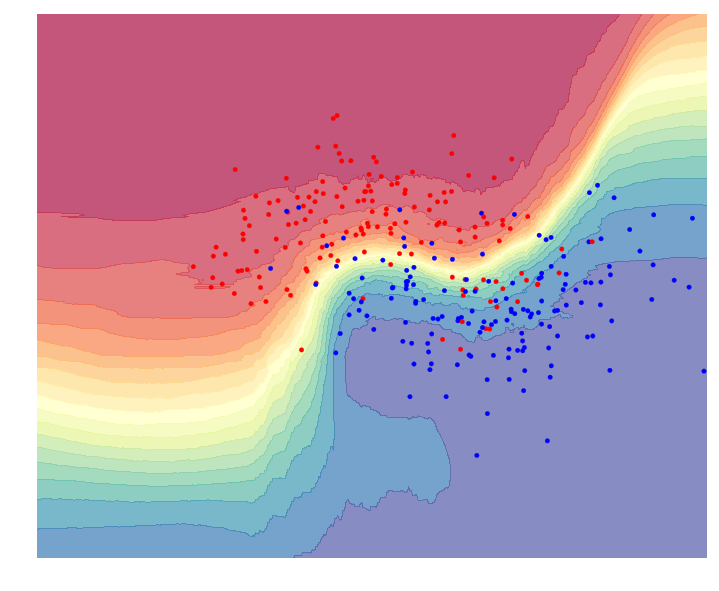

In [31]:
surface = simple_blending_features(classifiers,
                                   LogisticRegression(C=5, random_state=RANDOM_STATE),
                                   X_train, np.c_[xx.ravel(), yy.ravel()], y_train,
                                   part1_ratio=0.6,
                                   random_state=RANDOM_STATE).reshape(xx.shape)
plt.contourf(xx, yy, surface, levels=np.linspace(surface.min(), surface.max(), 20), cmap=plt.cm.Spectral, alpha=0.7)
plt.scatter(X_test[:, 0], X_test[:, 1], c=pd.Series(y_test).map({0:'red', 1:'blue'}), s=20, alpha=1.0)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')

## Усреднение нескольких простейших блендингов с разным разбиением

Логичным продолжением совершенствования схемы, является усреднение нескольких таких блендингов, используя разное разбиение тренировочной выборки. Таким образом базовые алгоритмы и мета-алгоритм теперь используют всю доступную обучающую выборку.

In [32]:
def average_blending(basic_algorithms, meta_algorithm, X_train, X_test, y_train, part1_ratio=0.9, n_iter=3, random_state=None):

    simple_blending_realizations = list()
    for iter in range(n_iter):
        if random_state is None:
            realization_random_state = None
        else:
            realization_random_state = iter + random_state

        simple_blending_realizations.append(simple_blending(basic_algorithms,
                                                            meta_algorithm,
                                                            X_train, X_test, y_train,
                                                            part1_ratio=part1_ratio,
                                                            random_state=realization_random_state))
    return np.mean(np.asarray(simple_blending_realizations), axis=0)

In [33]:
experiments = list()
for i in range(1, 10):
    average_blending_predictions = average_blending(classifiers,
                                                LogisticRegression(C=5, random_state=RANDOM_STATE),
                                                X_train, X_test, y_train,
                                                part1_ratio=0.9,
                                                n_iter=10,
                                                random_state=i)
    experiments.append(roc_auc_score(y_test, average_blending_predictions))
print('mean roc_auc: {0}\nstd: {1}'.format(round(np.mean(experiments), 4), round(np.std(experiments), 5)))

mean roc_auc: 0.9216
std: 0.00026


Закономерно получили небольшое увеличение качества, сделав ансамбль более стабильным

(-3.0, 3.0, -3.0, 3.0)

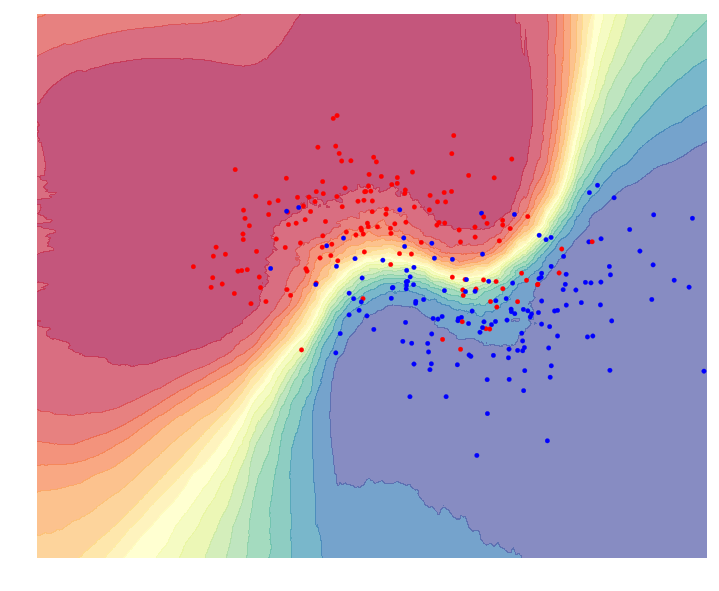

In [34]:
surface = average_blending(classifiers,
                           LogisticRegression(C=5, random_state=RANDOM_STATE),
                           X_train, np.c_[xx.ravel(), yy.ravel()], y_train,
                           part1_ratio=0.9,
                           n_iter=10,
                           random_state=RANDOM_STATE).reshape(xx.shape)
plt.contourf(xx, yy, surface, levels=np.linspace(surface.min(), surface.max(), 20), cmap=plt.cm.Spectral, alpha=0.7)
plt.scatter(X_test[:, 0], X_test[:, 1], c=pd.Series(y_test).map({0:'red', 1:'blue'}), s=20, alpha=1.0)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')

## Усреднение нескольких простейших блендингов с разным разбиением (признаки + мета-признаки)

Как еще один пример, реализация предыдущей схемы с объединением обычных признаков с мета-признаками. Далее, в следующих схемах, такой прием использоваться не будет, но если нужно то его очень легко добавить.

In [35]:
def average_blending_features(basic_algorithms, meta_algorithm, X_train, X_test, y_train, part1_ratio=0.5, n_iter=3, random_state=None):

    simple_blending_realizations = list()
    for iter in range(n_iter):
        if random_state is None:
            realization_random_state = None
        else:
            realization_random_state = iter + random_state

        simple_blending_realizations.append(simple_blending_features(basic_algorithms,
                                                                     meta_algorithm,
                                                                     X_train, X_test, y_train,
                                                                     part1_ratio=part1_ratio,
                                                                     random_state=realization_random_state))
    return np.mean(np.asarray(simple_blending_realizations), axis=0)

In [55]:
experiments = list()
for i in range(1, 10):
    average_blending_features_predictions = average_blending_features(classifiers,
                                                                      LogisticRegression(C=5, random_state=RANDOM_STATE),
                                                                      X_train, X_test, y_train,
                                                                      part1_ratio=0.5,
                                                                      n_iter=10,
                                                                      random_state=i)
    experiments.append(roc_auc_score(y_test, average_blending_features_predictions))
print('mean roc_auc: {0}\nstd: {1}'.format(round(np.mean(experiments), 4), round(np.std(experiments), 5)))

mean roc_auc: 0.9246
std: 0.00038


Снова, на удивление всему что только можно, получили большой прирост в качестве, не потеряв в стабильности. Как и говорилось ранее, объединение признаков и мета-признаков иногда бывает лучше просто блендинга над мета-признаками.

(-3.0, 3.0, -3.0, 3.0)

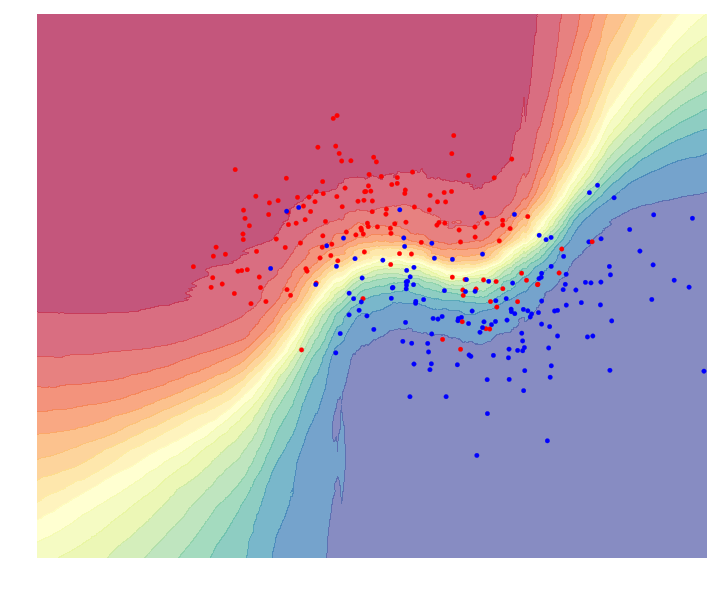

In [37]:
surface = average_blending_features(classifiers,
                                    LogisticRegression(C=5, random_state=RANDOM_STATE),
                                    X_train, np.c_[xx.ravel(), yy.ravel()], y_train,
                                    part1_ratio=0.5,
                                    n_iter=10,
                                    random_state=RANDOM_STATE).reshape(xx.shape)
plt.contourf(xx, yy, surface, levels=np.linspace(surface.min(), surface.max(), 20), cmap=plt.cm.Spectral, alpha=0.7)
plt.scatter(X_test[:, 0], X_test[:, 1], c=pd.Series(y_test).map({0:'red', 1:'blue'}), s=20, alpha=1.0)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')

## Модификация блендинга

Другая модификацией блендинга, которая призвана стать более эффективной в смысле достижимого качества. Общая идея такая: делим выборку на N частей, где каждую часть в свою очередь делим тоже на 2 части. Теперь эти N пар частей обучающей выборки используются для N реализация блендинга. Финальные предсказания всех этих блэндингов усредняются.

Схема сложна в реализация и по факту оказывается не очень удачной. Можно модифицировать и этот вариант, опять таки усреднив несколько реализаций и осуществляя разбиения по принципу бутсрапа. Минус все тот же, не используется полный объем обучающей выборки.

<img src="../../img/splits_blending.png">

In [38]:
def splits_blending(basic_algorithms, meta_algorithm, X_train, X_test, y_train, n_splits=3, part1_ratio=0.6, random_state=None):
    X_train, y_train = shuffle(X_train, y_train, random_state=random_state)

    splits_results = list()
    for split_indexes in np.array_split(np.array(range(X_train.shape[0])), n_splits):
        X_train_split = X_train[split_indexes]
        y_train_split = y_train[split_indexes]

        X_train_part1, X_train_part2, \
        y_train_part1, y_train_part2 = train_test_split(X_train_split, y_train_split, test_size=1 - part1_ratio,
                                                        random_state=random_state)

        meta_features_part2 = np.zeros((X_train_part2.shape[0], len(basic_algorithms)))
        meta_features_test = np.zeros((X_test.shape[0], len(basic_algorithms)))
        
        for index, basic_algorithm in enumerate(basic_algorithms):
            basic_algorithm.fit(X_train_part1, y_train_part1)

            part2_predictions = basic_algorithm.predict_proba(X_train_part2)[:, 1]
            meta_features_part2[:, index] = part2_predictions

            test_predictions = basic_algorithm.predict_proba(X_test)[:, 1]
            meta_features_test[:, index] = test_predictions


        meta_algorithm.fit(meta_features_part2, y_train_part2)
        splits_results.append(meta_algorithm.predict_proba(meta_features_test)[:, 1])


    return np.mean(np.asarray(splits_results), axis=0)

In [56]:
experiments = list()
for i in range(1, 10):
    splits_blending_predictions = splits_blending(classifiers,
                                              LogisticRegression(C=5, random_state=RANDOM_STATE),
                                              X_train, X_test, y_train,
                                              n_splits=3,
                                              part1_ratio=0.8,
                                              random_state=i)
    experiments.append(roc_auc_score(y_test, splits_blending_predictions))
print('mean roc_auc: {0}\nstd: {1}'.format(round(np.mean(experiments), 4), round(np.std(experiments), 5)))

mean roc_auc: 0.9188
std: 0.0019


Ожидаемо, получили качество похуже, но все еще сравнимое с лучшей моделью, причем среднеквадратическое отклонение запусков снизилось в 3-4 раза.

(-3.0, 3.0, -3.0, 3.0)

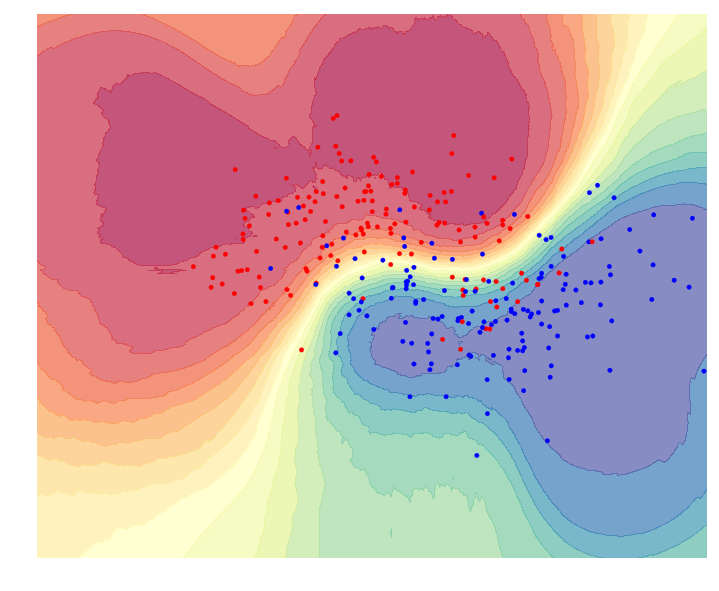

In [40]:
surface = splits_blending(classifiers,
                          LogisticRegression(C=5, random_state=RANDOM_STATE),
                          X_train, np.c_[xx.ravel(), yy.ravel()], y_train,
                          n_splits=3,
                          part1_ratio=0.8,
                          random_state=RANDOM_STATE).reshape(xx.shape)
plt.contourf(xx, yy, surface, levels=np.linspace(surface.min(), surface.max(), 20), cmap=plt.cm.Spectral, alpha=0.7)
plt.scatter(X_test[:, 0], X_test[:, 1], c=pd.Series(y_test).map({0:'red', 1:'blue'}), s=20, alpha=1.0)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')

## Конкатенация нескольких простейших блендингов с разным разбиением

Следующий вариант модификации блендинга. Отличается тем, что мета-признаки второй части разных разбиений не сразу идут на обучение мета-алгоритму, а конкатенируются. Аналогичная ситуация и с мета-признаками тестовой выборки. В финальном векторе ответов от мета-алгоритма содержатся несколько ответов для каждого объекта, так как конкатенируются несколько тестовых выборок. Их усредняют.

В итоге такая схема является более схожной в реализации и не гарантирует существенного прироста в качестве.

<img src="../../img/concatenate_blending.png">

In [41]:
def concatenate_blending(basic_algorithms, meta_algorithm, X_train, X_test, y_train, part1_ratio=0.9, n_iter=3, random_state=None):

    def blending_realization(basic_algorithms, X_train, y_train, X_test, part1_ratio, random_state):
        X_train_part1, X_train_part2, \
        y_train_part1, y_train_part2 = train_test_split(X_train, y_train, test_size=1 - part1_ratio,
                                                        random_state=random_state)

        meta_features_part2 = np.zeros((X_train_part2.shape[0], len(basic_algorithms)))
        meta_features_test = np.zeros((X_test.shape[0], len(basic_algorithms)))

        for index, basic_algorithm in enumerate(basic_algorithms):
            basic_algorithm.fit(X_train_part1, y_train_part1)

            part2_predictions = basic_algorithm.predict_proba(X_train_part2)[:, 1]
            meta_features_part2[:, index] = part2_predictions

            test_predictions = basic_algorithm.predict_proba(X_test)[:, 1]
            meta_features_test[:, index] = test_predictions

        return (meta_features_part2, y_train_part2, meta_features_test)

    realizations = list()
    for iter in range(n_iter):
        if random_state is None:
            realization_random_state = None
        else:
            realization_random_state = iter + random_state

        realizations.append(blending_realization(basic_algorithms, X_train, y_train, X_test, part1_ratio, random_state=realization_random_state))

    X_meta = np.concatenate([x[0] for x in realizations])
    y_meta = np.concatenate([x[1] for x in realizations])
    X_meta_test = np.concatenate([x[2] for x in realizations])

    meta_algorithm.fit(X_meta, y_meta)
    predictions = meta_algorithm.predict_proba(X_meta_test)[:, 1]

    return np.mean(predictions.reshape(-1, X_test.shape[0]), axis=0)

In [42]:
experiments = list()
for i in range(1, 10):
    concatenate_blending_predictions = concatenate_blending(classifiers,
                                                            LogisticRegression(C=5, random_state=RANDOM_STATE),
                                                            X_train, X_test, y_train,
                                                            part1_ratio=0.9,
                                                            n_iter=10,
                                                            random_state=i)
    experiments.append(roc_auc_score(y_test, concatenate_blending_predictions))
print('mean roc_auc: {0}\nstd: {1}'.format(round(np.mean(experiments), 4), round(np.std(experiments), 5)))

mean roc_auc: 0.9218
std: 0.00051


(-3.0, 3.0, -3.0, 3.0)

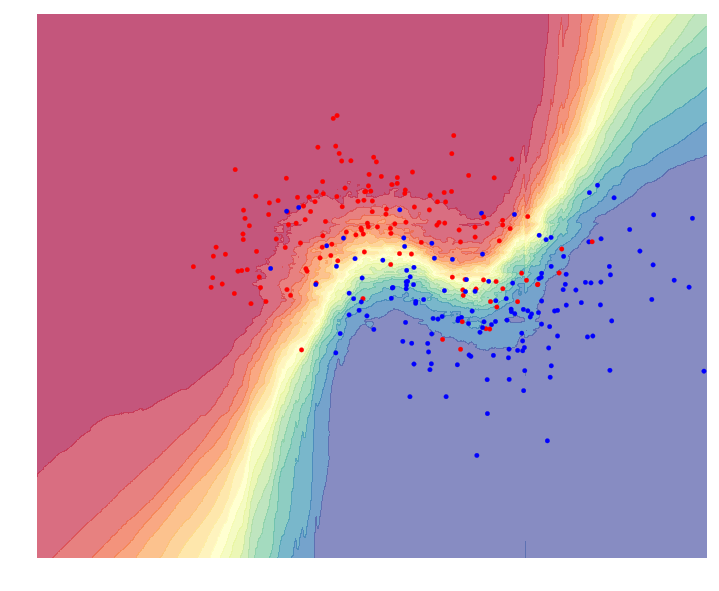

In [43]:
surface = concatenate_blending(classifiers,
                               LogisticRegression(C=5, random_state=RANDOM_STATE),
                               X_train, np.c_[xx.ravel(), yy.ravel()], y_train,
                               part1_ratio=0.9,
                               n_iter=10,
                               random_state=RANDOM_STATE).reshape(xx.shape)
plt.contourf(xx, yy, surface, levels=np.linspace(surface.min(), surface.max(), 20), cmap=plt.cm.Spectral, alpha=0.7)
plt.scatter(X_test[:, 0], X_test[:, 1], c=pd.Series(y_test).map({0:'red', 1:'blue'}), s=20, alpha=1.0)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')

## Классический стэкинг с усредненим предсказаний

Наконец мы добрались до самого стэкинга, призванного решить проблему использования всей обучающей выборки.

Выборку делят на несколько фолдов, все базовые алгоритмы обучают на всех фолдах кроме одного, а для последнего оставшегося делают предсказания. Так получаются мета-признаки для текущей части. Это процесс повторяется несколько раз, пока каждый фолд не выступит в роли "предсказательного". Сконкатенируя их вместе получим данные для обучения мета-алгоритма.

Мета-признаки для теста получают также во время тасовки фолдов. Базовые алгоритмы, обученные на всех фолдах кроме одного, делают предсказания для тестовой выборки, причем сколько фолдов столько и вариантов предсказаний. Все полученные мета-признаки для теста усредняют и подают на вход мета-алгоритму. Так же как и в блендинге, в стэкинге желательно сделать несколько разных разбиений на фолды, которые потом усредняются.

В случае когда K = |X| получается случай по типу leave-one-out.

Преимущества:
* используется вся обучающая выборка
* стабильная схема в плане достижения качества

Минусом является то, что мета-признаки для обучения мета-алгоритма и мета-признаки тестовой части разные, это является следствием следующих недостатков:
* тренировочные мета-признаки состоят из разных кусочков, полученных от разных базовых алгоритмов с разными гиперпараметрами
* усреднение меняет тестовые значения мета-признаков, например {0, 1} значения мета-признаков на трейне могут стать числами с плавающей точкой на тесте

С первым недостатком борются с помощью наложения нормального шума на мета-признаки, что является своего рода регуляризацией

<img src="../../img/average_kfold_stacking.png">

In [44]:
def average_kfold_stacking(basic_algorithms, meta_algorithm, X_train, X_test, y_train, n_folds=3, n_iter=3, noise_scale=0, random_state=None):

    realizations = list()

    for iter in range(n_iter):
        if random_state is None:
            realization_random_state = None
        else:
            realization_random_state = iter + random_state

        folds_results = list()
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=realization_random_state)
        for train_index, test_index in skf.split(X_train, y_train):
            X_train_folds, X_test_fold = X_train[train_index], X_train[test_index]
            y_train_folds, y_test_fold = y_train[train_index], y_train[test_index]

            fold_meta_features = np.zeros((X_test_fold.shape[0], len(basic_algorithms)))
            meta_features_test = np.zeros((X_test.shape[0], len(basic_algorithms)))

            for index, basic_algorithm in enumerate(basic_algorithms):
                basic_algorithm.fit(X_train_folds, y_train_folds)

                test_fold_predictions = basic_algorithm.predict_proba(X_test_fold)[:, 1]
                fold_meta_features[:, index] = normal(test_fold_predictions, scale=noise_scale)

                test_predictions = basic_algorithm.predict_proba(X_test)[:, 1]
                meta_features_test[:, index] = normal(test_predictions, scale=noise_scale)

            folds_results.append((fold_meta_features, y_test_fold, meta_features_test))

        meta_features = np.concatenate([x[0] for x in folds_results])
        meta_y = np.concatenate([x[1] for x in folds_results])

        meta_test = np.mean(np.asarray([x[2] for x in folds_results]), axis=0)

        meta_algorithm.fit(meta_features, meta_y)
        realizations.append(meta_algorithm.predict_proba(meta_test)[:, 1])

    return np.mean(np.asarray(realizations), axis=0)

In [45]:
experiments = list()
for i in range(1, 10):
    average_kfold_stacking_predictions = average_kfold_stacking(classifiers,
                                                    LogisticRegression(C=5, random_state=RANDOM_STATE),
                                                    X_train, X_test, y_train,
                                                    n_folds=5,
                                                    n_iter=5,
                                                    noise_scale=0,
                                                    random_state=i)
    experiments.append(roc_auc_score(y_test, average_kfold_stacking_predictions))
print('mean roc_auc: {0}\nstd: {1}'.format(round(np.mean(experiments), 4), round(np.std(experiments), 5)))

mean roc_auc: 0.9224
std: 0.00012


В данном случае стэкинг работет получше большинста блендингов, что в плане качестве, что в плане стабильности. Давайте попробуем добавить шум для мета-признаков:

In [46]:
experiments = list()
for i in range(1, 10):
    average_kfold_stacking_predictions = average_kfold_stacking(classifiers,
                                                    LogisticRegression(C=5, random_state=RANDOM_STATE),
                                                    X_train, X_test, y_train,
                                                    n_folds=5,
                                                    n_iter=5,
                                                    noise_scale=0.02,
                                                    random_state=i)
    experiments.append(roc_auc_score(y_test, average_kfold_stacking_predictions))
print('mean roc_auc: {0}\nstd: {1}'.format(round(np.mean(experiments), 4), round(np.std(experiments), 5)))

mean roc_auc: 0.922
std: 0.00047


Не трудно догадаться, что это было лишним, но возможно стоит понастраивать разные параметры самого стэкинга.

(-3.0, 3.0, -3.0, 3.0)

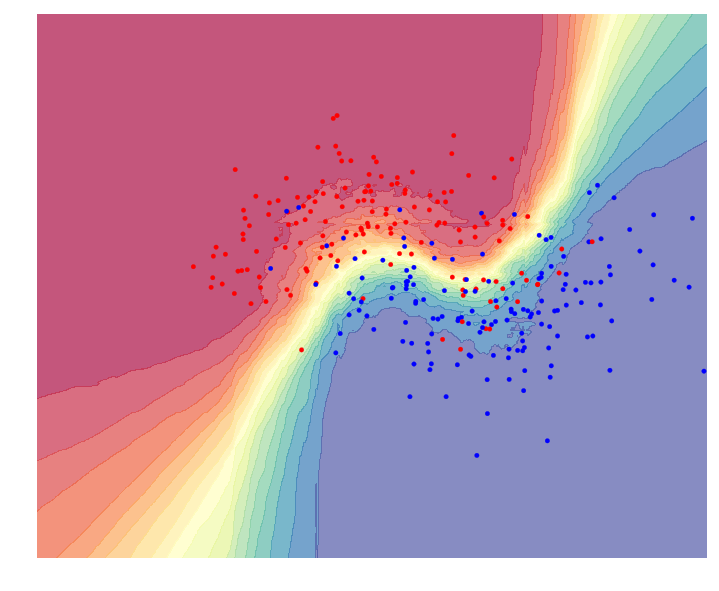

In [47]:
surface = average_kfold_stacking(classifiers,
                                 LogisticRegression(C=5, random_state=RANDOM_STATE),
                                 X_train, np.c_[xx.ravel(), yy.ravel()], y_train,
                                 n_folds=5,
                                 n_iter=5,
                                 noise_scale=0,
                                 random_state=RANDOM_STATE).reshape(xx.shape)
plt.contourf(xx, yy, surface, levels=np.linspace(surface.min(), surface.max(), 20), cmap=plt.cm.Spectral, alpha=0.7)
plt.scatter(X_test[:, 0], X_test[:, 1], c=pd.Series(y_test).map({0:'red', 1:'blue'}), s=20, alpha=1.0)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')

## Классический стэкинг

Собственно отличие от предыдущей реализации в том, что мета-признаки для тестовой части делают не базовые алгоритмы, обученные на фолдах, а совершенно новые, обученные на всей обучающей выборке, включающую все фолды. Мета-признаки конкатенируются по колонкам и отправляются мета-алгоритму на вход.

И точно также как и в предыдущей реализация мета-признаки теста и трейна разные, только в этот раз признаки на контроле являются ответом совершенно других, снова обученных базовых алгоритмов.

<img src="../../img/classical_stacking.png">

In [48]:
def classical_stacking(basic_algorithms, meta_algorithm, X_train, X_test, y_train, n_folds=3, n_iter=3, noise_scale=0, random_state=None):

    realizations = list()

    for iter in range(n_iter):
        if random_state is None:
            realization_random_state = None
        else:
            realization_random_state = iter + random_state

        folds_results = list()
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=realization_random_state)
        for train_index, test_index in skf.split(X_train, y_train):
            X_train_folds, X_test_fold = X_train[train_index], X_train[test_index]
            y_train_folds, y_test_fold = y_train[train_index], y_train[test_index]

            fold_meta_features = np.zeros((X_test_fold.shape[0], len(basic_algorithms)))

            for index, basic_algorithm in enumerate(basic_algorithms):
                basic_algorithm.fit(X_train_folds, y_train_folds)
                test_fold_predictions = basic_algorithm.predict_proba(X_test_fold)[:, 1]
                fold_meta_features[:, index] = normal(test_fold_predictions, scale=noise_scale)

            folds_results.append((fold_meta_features, y_test_fold))

        meta_features = np.concatenate([x[0] for x in folds_results])
        meta_y = np.concatenate([x[1] for x in folds_results])


        meta_features_test = np.zeros((X_test.shape[0], len(basic_algorithms)))
        for index, basic_algorithm in enumerate(basic_algorithms):
            basic_algorithm.fit(X_train, y_train)
            test_predictions = basic_algorithm.predict_proba(X_test)[:, 1]
            meta_features_test[:, index] = normal(test_predictions, scale=noise_scale)

        meta_algorithm.fit(meta_features, meta_y)

        realizations.append(meta_algorithm.predict_proba(meta_features_test)[:, 1])

    return np.mean(np.asarray(realizations), axis=0)

In [49]:
experiments = list()
for i in range(1, 10):
    classical_stacking_predictions = classical_stacking(classifiers,
                                                    LogisticRegression(C=5, random_state=RANDOM_STATE),
                                                    X_train, X_test, y_train,
                                                    n_folds=5,
                                                    n_iter=5,
                                                    noise_scale=0,
                                                    random_state=i)
    experiments.append(roc_auc_score(y_test, classical_stacking_predictions))
print('mean roc_auc: {0}\nstd: {1}'.format(round(np.mean(experiments), 4), round(np.std(experiments), 5)))

mean roc_auc: 0.9209
std: 0.00022


На данной выборке, такая реализация стэкинга рабоет похуже, бывает.

In [50]:
experiments = list()
for i in range(1, 10):
    classical_stacking_predictions = classical_stacking(classifiers,
                                                    LogisticRegression(C=5, random_state=RANDOM_STATE),
                                                    X_train, X_test, y_train,
                                                    n_folds=5,
                                                    n_iter=5,
                                                    noise_scale=0.02,
                                                    random_state=i)
    experiments.append(roc_auc_score(y_test, classical_stacking_predictions))
print('mean roc_auc: {0}\nstd: {1}'.format(round(np.mean(experiments), 4), round(np.std(experiments), 5)))

mean roc_auc: 0.9205
std: 0.00123


И точно также шум не помог.

(-3.0, 3.0, -3.0, 3.0)

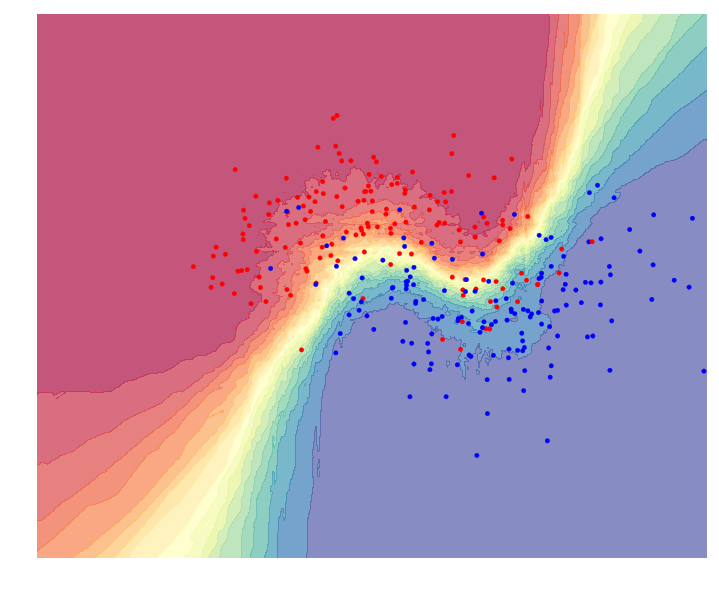

In [51]:
surface = classical_stacking(classifiers,
                             LogisticRegression(C=5, random_state=RANDOM_STATE),
                             X_train, np.c_[xx.ravel(), yy.ravel()], y_train,
                             n_folds=5,
                             n_iter=5,
                             noise_scale=0,
                             random_state=RANDOM_STATE).reshape(xx.shape)
plt.contourf(xx, yy, surface, levels=np.linspace(surface.min(), surface.max(), 20), cmap=plt.cm.Spectral, alpha=0.7)
plt.scatter(X_test[:, 0], X_test[:, 1], c=pd.Series(y_test).map({0:'red', 1:'blue'}), s=20, alpha=1.0)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.axis('off')

Существуют и другие реализации стэкинга, в том числе и улучшение предыдущей схемы, но в целом основная идея такая же как и в предыдущих схемах. Теперь зная как это работает, вы можете написать и адаптировать стэкинг и блендинг под любую задачу)

# Заметки

* Не всегда блендинг и стэкинг **существенно превышают** качество лучшего из базовых алгоритмов, но почти всегда такой ансамбль оказывается **намного стабильней** одиночного решения, что дает плюс в копилку на соревнованиях;
* Если из ансамбля убрать лучший базовый алгоритм, то финальное качество падает не сильно;
* Традиционно в бустинге и бэггинге используются алгоритмы одной природы, в стэкинге и блендинге разной;
* При умелом подходе и умеренном использованни стэкинг применяется в реальных бизнес задачах, например, если нужно очень стабильное решение в угоду интерпретированности;
* В задаче бинарной классификации, с функцией ошибки log_loss, тяжело придумать ансамбль, который их улучшит.

<img src="./../img/kaggle.png">

# Практические советы для стекинга и не только

* Чтобы выжать максимум качества, для конкретных решений пишите конкретные реализации ансамблей, библиотеки же можно использовать для первых заходов;
* Самое важное, используйте стекинг только тогда, когда вы уверены, что выжали максимум информации из данных. Один "хороший признак" под конкретную модель стоит нескольких ансамблей
* Пристыковывать мета-признаки к обычным признакам в этих семах лучше не стоит, но иногда все-таки может быть улучшение качества;
* Добавляйте шум (возможно не только нормальный) к мета-признакам для "регуляризации", если это дает прирост в качестве;
* Используйте стэкинг преимущественно на больших выборках, измеряющихся десятками тысяч. На маленьких выборках нужно аккуратно подбирать базовые и мета- алгоритмы;
* В стэкинге и блендинге используйте алгоритмы разной природы (ближайшие соседи, линейные, деревянные, нейронные сети и др);
* Иногда может оказаться полезной деформация признакового пространства, то есть вместо мета-признаков (ответы моделей) использовать мономы над ними, например все попарные произведения;
* Не забывайте настраивать параметры самого стэкинга, так чтобы было максимальное качество за приемлемое время работы;
* Мета-алгоритм должен оптимизировать ваш функционал, от базовых алгоритмов это не требуется. Речь идет об 1 уровневом ансамбле;
* Можно обобщить несколько стекингов и блендингов в еще один стекинг (многоуровневый), но делайте так только с спротивных задачах, например при работе в команде;
* Стэкинг - это machine learning над сильно скоррелированными между собой мета-признаками и целевой переменной, поэтому предъявите особые требования к регуляризации;
* Используйте базовые алгоритмы с плохокоррелированными ошибками, такое сочетание позволяет достичь значительно большего качества. Например можно построить корреляционную матрицу Пирсона над ответами моделей и выбрать наименее скоррелированные;
* В больших ансамблях лучше использовать слабо регуляризованные классификаторы, которые фактически переобучены на обучающей выборке, это позволяет сократить дисперсию;
* Метод случайных подпространств работают лучше всего на выборках с большим числом признаков и не совсем малым числом примеров;
* Практический опыт: нет смысла использовать разные классификаторы на одном и том же множестве признаков, зато целесообразно использовать один классификатор на разных подмножествах признаков;
* В случае значительных шумов бэггинг намного лучше бустинга;
* Бэггинг подходит для слабых нестабильных классификаторов с неубывающей кривой обучения (learning curve). Бустинг хорош в тех же условиях, но для больших размеров обучающей выборки. Метод случайного подпространства показывает неплохие характеристики в случае нестабильных слабых классификаторов с убывающей кривой обучения и малых размеров обучающей выборки;
* Ансамбль svm не приводит к улучшению точности по сравнению с одной правильно настроенной машиной, однако ансамбли более стабильны;
* DECORATE побеждает отдельно взятые классификаторы, бэггинг и случайные леса, а также превосходит AdaBoost на малых выборках и сравним на больших;
* Бэггинг особенно эффективен на малых выборках;
* Можно добавать кластеризацию данных как мета-признак, например kmeans или 2-3 признака от t-SNE;
* Геометрическое усреднение чаще превосходит обычное;
* Для объединения в ансамбль плохо откалибровнных алгоритмов можно использовать rank average. Это особенно хорошо работает на ранках и threshold-based метриках типа AUC;
* Feature-WeightedLinear Stacking реализован в Vowpal Wabbit;
* Хорошей практикой является использование классификаторов для ансамблей с задачей регрессии. Так первоначальный вектор y делят на зоны, которые и становятся своебразными классами. Такой классификатор должен помочь в ансамбле регрессоров;
* Одни из вариантов построения ансамблей: жадный, где ансамбли добавляются в композицию, только в случае общего улучшения качестве и брутфорс, при котором строится множество случайных ансамблей и выбирается лучший(ие).

# Выводы

Резюмируя, вы ознакомились с ансамблированием и заглянули под капот таким схемам как блендинг и стэкинг. Теперь при возможности с легкостью написать их самим и адаптировать под конкретную задачу. Кроме того, можно реализовать и другие методы из списка в самом начале, благо статьи на эти темы есть.

Пару слов о датасете, использованного в этом тьюториале. Он оказался не очень показательным, так как конкретно эту задачу классификации ближайшие соседи решают максимально близко к возможному, поэтому ансамбли не дают существенного прироста. Но никто и не говорил, что смесь моделей всегда будет превосходить отдельные модели. Тем не менее на kaggle, если вы вверху списка публичного рейтинга, любые улучшения дадут вам несколько позиций вверх. Кто знает, может это будет золото?)

Как бонус, используйте готовые библиотеки [brew](https://github.com/viisar/brew) и [heamy](https://github.com/rushter/heamy).

# Список литературы

[1] [Cтекинг (Stacking) и блендинг (Blending)](https://alexanderdyakonov.wordpress.com/2017/03/10/c%D1%82%D0%B5%D0%BA%D0%B8%D0%BD%D0%B3-stacking-%D0%B8-%D0%B1%D0%BB%D0%B5%D0%BD%D0%B4%D0%B8%D0%BD%D0%B3-blending/)

[2] [История развития ансамблевых методов классификации в машинном обучении](https://www.researchgate.net/publication/278019662_Istoria_razvitia_ansamblevyh_metodov_klassifikacii_v_masinnom_obucenii?enrichId=rgreq-4227f37e04a649e6c2644493d49b3b8a-XXX&enrichSource=Y292ZXJQYWdlOzI3ODAxOTY2MjtBUzoyMzg4OTM5NDk3Nzk5NjhAMTQzMzk2ODE2NDM0Mg%3D%3D&el=1_x_3&_esc=publicationCoverPdf)

[3] [Методы ансамблирования обучающихся алгоритмов](http://www.machinelearning.ru/wiki/images/5/56/Guschin2015Stacking.pdf)

[4] [Градиентный бустинг лекция 9](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture09-ensembles.pdf)

[5] [Градиентный бустинг лекция 10](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture10-ensembles.pdf)

[6] [A Kaggler's Guide to Model Stacking in Practice](http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/)

[7] [KAGGLE ENSEMBLING GUIDE](https://mlwave.com/kaggle-ensembling-guide/)

[8] [Statistical Pattern Recognition](http://www4.comp.polyu.edu.hk/~csajaykr/myhome/teaching/biometrics/spr_pami.pdf)

[9] [Stacked regressions](https://rd.springer.com/article/10.1007%2FBF00117832)

[10] [Bagging Predictors](https://rd.springer.com/article/10.1023%2FA%3A1018054314350)

[11] [Feature-Weighted Linear Stacking](https://arxiv.org/pdf/0911.0460.pdf?lipi=urn%253Ali%253Apage%253Ad_flagship3_pulse_read%253BPZ4T3JLHTu%252BOWNI0d5kFbg%253D%253D)

[12] [Combining Predictions for Accurate Recommender Systems](http://elf-project.sourceforge.net/CombiningPredictionsForAccurateRecommenderSystems.pdf?lipi=urn%3Ali%3Apage%3Ad_flagship3_pulse_read%3BPZ4T3JLHTu%2BOWNI0d5kFbg%3D%3D)

[13] [The BigChaos Solution to the Netflix Grand Prize](https://www.netflixprize.com/assets/GrandPrize2009_BPC_BigChaos.pdf)

[14] [Computer Vision for Head Pose Estimation: Review of a Competition](http://vision.cs.tut.fi/data/publications/scia2015_hpe.pdf)

[15] [Ensemble selection from libraries models](http://www.cs.cornell.edu/~caruana/ctp/ct.papers/caruana.icml04.icdm06long.pdf)

[16] [The sum is greater than the parts](http://www.columbia.edu/~rsb2162/PBGH-SIGKDDExp.pdf)